In [3]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import glob
import math

In [1]:
path = '/home/jtindall/WatChMaL/outputs/2021-01-09/gan_full_1/outputs'

In [5]:
image_batches = [np.load(fname,allow_pickle=True)['gen_imgs'] for fname in glob.glob(os.path.join(path,'imgs/*'))]
print(len(image_batches))

test_batch = image_batches[0]
print(test_batch.shape)

test_image = test_batch[0]
print(test_image.shape)

108
(64, 19, 40, 40)
(19, 40, 40)


In [6]:
# Load tubes information
geo_path = '/fast_scratch/WatChMaL/data/mPMT_full_geo.npz'
geofile = np.load(geo_path, allow_pickle=True)

tubes = geofile[ 'tube_no' ]
tube_xyz = geofile[ 'position' ]

print(tubes.shape)
print(tubes)

(15808,)
[    1     2     3 ... 15806 15807 15808]


In [7]:
# Load positions information
mpmt_positions_file = '/data/WatChMaL/data/IWCD_mPMT_image_positions.npz'
mpmt_positions   = np.load(mpmt_positions_file)['mpmt_image_positions']

data_size = np.max(mpmt_positions, axis=0) + 1
n_channels = pmts_per_mpmt = 19
data_size = np.insert(data_size, 0, n_channels)

In [8]:
all_tubes = geofile[ 'tube_no' ]

In [30]:
# Silly off by one tube problem
hit_pmts = all_tubes - 1

In [31]:
# Get the mpmt that was hit
hit_mpmts = hit_pmts // pmts_per_mpmt
# Get the pmt within the module that was hit
hit_pmt_in_modules = hit_pmts % pmts_per_mpmt

In [32]:
print(hit_pmts.shape)
print(hit_mpmts.shape)
print(hit_pmt_in_modules.shape)

(15808,)
(15808,)
(15808,)


In [33]:
print(hit_pmt_in_modules[0:30])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18  0  1  2  3  4
  5  6  7  8  9 10]


In [34]:
hit_rows = mpmt_positions[hit_mpmts, 0]
hit_cols = mpmt_positions[hit_mpmts, 1]

In [37]:
print(hit_rows)
print(hit_cols)

[26 26 26 ... 39 39 39]
[ 0  0  0 ... 19 19 19]


In [38]:
# TODO: fix barrel array indexing to match endcaps in xyz ordering
#sample_data[:, 12:28, :] = sample_data[barrel_map_array_idxs, 12:28, :]
hit_data = test_image[hit_pmt_in_modules, hit_rows, hit_cols]

In [55]:
# TODO: screening for negative values, should fix
hit_data[hit_data < 0 ] = 0

In [39]:
print(hit_data.shape)

(15808,)


In [49]:
# Load tank params
tube_x   = tube_xyz[:,0]
R =  (tube_x.max() - tube_x.min())/2.0

preimage_dimensions = [2506, 2317]

#full_tank_tube_dir = full_tank_geofile[ 'orientation']

In [46]:
# Construct plotting functions for full tank data
def PMT_to_flat_cylinder_map_positive( tubes, tube_xyz ):
    """
    Build dictionary of PMT number, to (x,y) on a flat cylinder
    
    N.B. Tube numbers in full geometry file go from 1:NPMTs, but it seems like
    the event data number from 0:NPMTs-1, so subtracting 1 from tube number here?
    
    """
    mapping = {}
    for idx, tube in enumerate(tubes):
        x = tube_xyz[idx,0]
        y = tube_xyz[idx,1]
        z = tube_xyz[idx,2]
        if ( y > 500. ):
            # in top circle of cylinder
            xflat = x+1162.7
            yflat = 2165.2 + z
            mapping[ int( tube-1 ) ] = [ int(round(xflat)), int(round(yflat)) ]
            
        elif ( y < -500.):
            # in bottom circle of cylinder
            xflat = x+1162.7
            yflat = 370.1 + z
            mapping[ int( tube-1 ) ] = [ int(round(xflat)), int(round(yflat)) ]
            
        else:
            # in barrel part of cylinder
            theta = math.atan2( z, x )
            xflat = R * theta + 1162.7
            yflat = y + 1267.7
            mapping[ int( tube-1 ) ] = [ int(round(xflat)), int(round(yflat)) ]
    return mapping

PMTFlatMapPositive = PMT_to_flat_cylinder_map_positive( tubes, tube_xyz )

In [51]:
def EventDisplay( tubes, quantities, title="Charge", cutrange=[-1,-1] ):
    """
    tubes == np.array of PMTs that were hit
    quantities == np.array of PMT quantities (either charge or time)
    title == title to add to display
    cutrange == minimum and maximum values on plot (or set both same for default)
    """
    
    fig = plt.figure(figsize=[12,12]) 
    preimage = np.zeros( [2506, 2317] )
    #maxquantity = quantities.max()
    #preimage *= maxquantity*1.2
    imgmin = quantities.min()
    imgmax = quantities.max()
    for idx, tube in enumerate( tubes ):
        if cutrange[0] != cutrange[1]:
            if quantities[idx] < cutrange[0] or quantities[idx] > cutrange[1]:
                continue
        for dx in range(-3,4):
            for dy in range(-3,4):
                if abs(dx)==3 and abs(dy)==3:
                    continue
                    
                #print( "idx=", idx, " len(quantities)=",len(quantities), " tube=", tube, " len(PMTFlatMap)=", len(PMTFlatMapPositive))
                preimage[ PMTFlatMapPositive[tube][1]+dx, PMTFlatMapPositive[tube][0]+dy ] = quantities[idx]

    if cutrange[0] != cutrange[1]:
        imgmin = cutrange[0]
        imgmax = cutrange[1]
    plt.imshow( preimage, extent = [-1162.7,1162.7,-1267.7,1267.7], vmin=imgmin, vmax=imgmax )
    fig.suptitle(title, fontsize=20)
    plt.xlabel('Distance CCW on perimeter from x-axis (cm)', fontsize=18)
    plt.ylabel('Y (cm)', fontsize=16)
    #plt.set_cmap('YlGnBu')
    #plt.set_cmap('cubehelix_r')
    #plt.set_cmap('gnuplot2_r')
    plt.set_cmap('gist_heat_r')
    plt.colorbar()

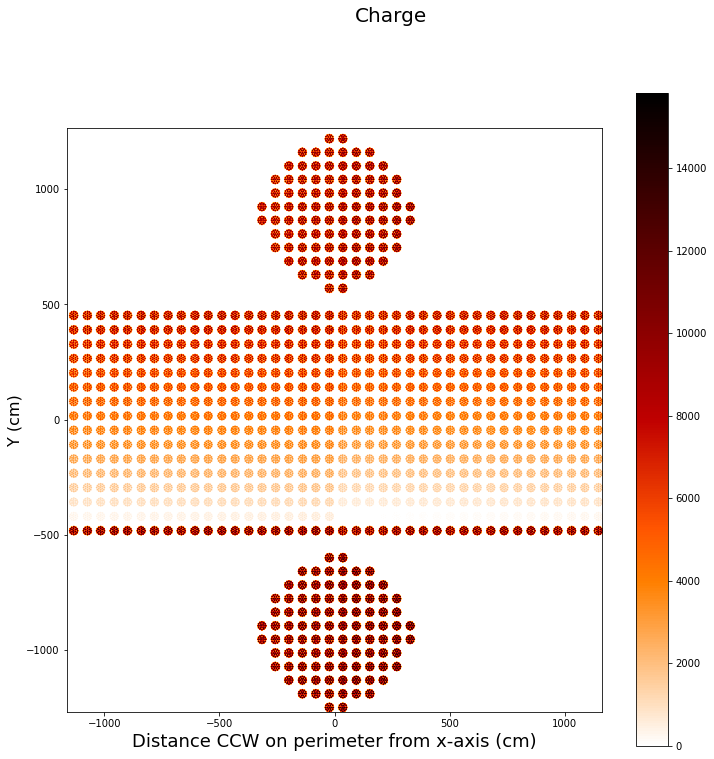

In [53]:
EventDisplay(hit_pmts, hit_pmts)

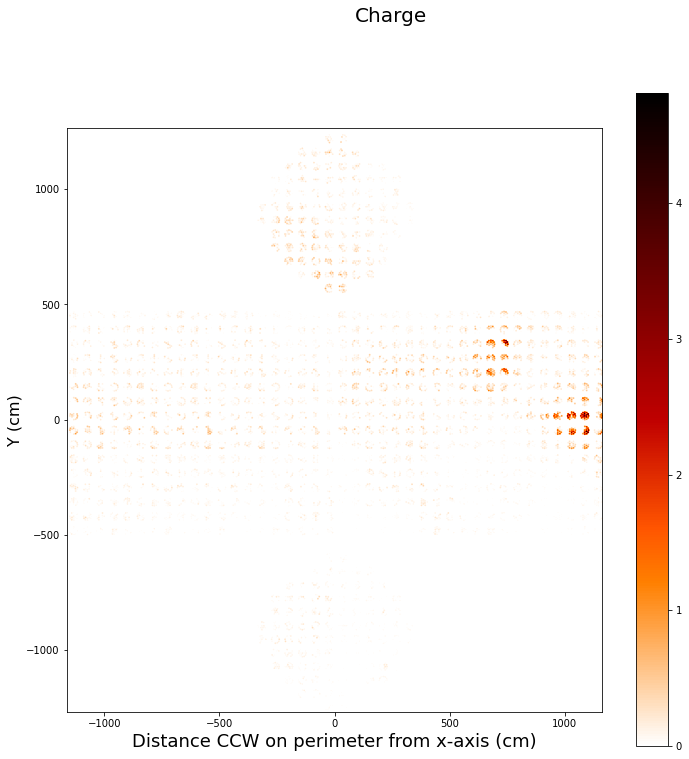

In [56]:
EventDisplay(hit_pmts, hit_data)